**Arquitetura**

Exemplo de uma arquitetura de CNN:

```python
model = Sequential([
    
    # Primeira Camada: 64 Filtros com tamanhos maiores (e sem Stride)
    Conv2D(filters=64, kernel_size=7, activation='relu', padding="same", input_shape=[28, 28, 1]),
    
    # Um Pool de tamanho 2 divide a dimensão espacial pela metade
    MaxPooling2D(pool_size=2),
    
    # 2 Camadas Convolucionais com 128 filtros cada, já com tamanho menor (3) e uma camada de MaxPooling após. Podemos repetir esta estrutura por n vezes, caso tenhamos imagens de tamanho grande.
    Conv2D(filters=128, kernel_size=3, activation='relu', padding="same"),
    Conv2D(filters=128, kernel_size=3, activation='relu', padding="same"),
    MaxPooling2D(pool_size=2),
    
    # Mais 2 Camadas Convolucionais seguidas por uma de MaxPooling, mas agora com mais filtros (256). A medida que vamos avançando nas camadas, aumentamos a quantidade de Filtros: 64, 128, 256, pois o número de características de nível inferior (captado pelas primeiras camadas) é menor que as de nível superior. Além disso, ao aplicarmos um MaxPolling(2), diminuimos a dimensão pela metade, portanto, é comum dobrarmos o número de filtros das próximas camadas, pois não corrermos o risco de explodir o número de parâmetros. 
    Conv2D(filters=256, kernel_size=3, activation='relu', padding="same"),
    Conv2D(filters=256, kernel_size=3, activation='relu', padding="same"),
    MaxPooling2D(pool_size=2),

    # Antes da Camada Densa, usamos uma camada para converter a Matriz 2D em Array 1D
    Flatten(),
    
    # Camada Densa com 128 neurônios, seguida por uma camada de Dropout para reduzir o overfitting
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    
    # Mais uma Densa, mas agora com 68 neurônios, e mais uma de Dropout
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    
    # Camada de Output com a quantidade de Classes
    Dense(units=10, activation='softmax'),
])
```

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Reshape, Flatten, Dense, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization

from keras.utils import np_utils

# Carregando o Dataset MNIST

In [37]:
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()
X_train_full.shape, y_train_full.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

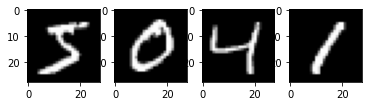

In [38]:
# Visualizando as imagens do dataset
plt.figure()
plt.subplot(1,4,1)
plt.imshow(X_train_full[0], cmap='gray')
plt.subplot(1,4,2)
plt.imshow(X_train_full[1], cmap='gray')
plt.subplot(1,4,3)
plt.imshow(X_train_full[2], cmap='gray')
plt.subplot(1,4,4)
plt.imshow(X_train_full[3], cmap='gray')
plt.show()

In [39]:
# Visualizando parte da 1a instância (valores RGB de 0 a 255): 
print(pd.DataFrame(X_train_full[0]).head(7))

   0   1   2   3   4   5   6   7   8   9   ...   18   19   20   21   22   23  \
0   0   0   0   0   0   0   0   0   0   0  ...    0    0    0    0    0    0   
1   0   0   0   0   0   0   0   0   0   0  ...    0    0    0    0    0    0   
2   0   0   0   0   0   0   0   0   0   0  ...    0    0    0    0    0    0   
3   0   0   0   0   0   0   0   0   0   0  ...    0    0    0    0    0    0   
4   0   0   0   0   0   0   0   0   0   0  ...    0    0    0    0    0    0   
5   0   0   0   0   0   0   0   0   0   0  ...  175   26  166  255  247  127   
6   0   0   0   0   0   0   0   0  30  36  ...  225  172  253  242  195   64   

   24  25  26  27  
0   0   0   0   0  
1   0   0   0   0  
2   0   0   0   0  
3   0   0   0   0  
4   0   0   0   0  
5   0   0   0   0  
6   0   0   0   0  

[7 rows x 28 columns]


As imagens deste Dataset são em escala de cinza. Ou seja, **possuem apenas 1 canal de cor.**

In [40]:
print('Formato inicial: ', X_train_full.shape, X_test.shape)

Formato inicial:  (60000, 28, 28) (10000, 28, 28)


Temos que aplicar um **reshape()** para informar que temos apenas 1 canal (escala de cinza), o que será necessário informar no parâmetro **'input_shape'** ao instanciarmos a Camada Convolucional 2D.

In [41]:
'''# reshape(batch_size, rows, columns, chanels)
X_train_full = X_train_full.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

print('Formato após reshape(): ', X_train_full.shape, X_test.shape)'''

"# reshape(batch_size, rows, columns, chanels)\nX_train_full = X_train_full.reshape(-1,28,28,1)\nX_test = X_test.reshape(-1,28,28,1)\n\nprint('Formato após reshape(): ', X_train_full.shape, X_test.shape)"

In [42]:
# Dividindo o conjunto de Treinamento em Train/Valid:

X_valid, X_train = X_train_full[:5000], X_train_full[5000:] # Features
y_valid, y_train = y_train_full[:5000], y_train_full[5000:] # Labels

In [43]:
# Escalonando (0 a 1) e convertendo para o tipo 'float' o conjunto de Treinamento.
# Ao dividirmos, ele já irá converter para 'float', senão precisaríamos converter com X_valid.astype('float32').

X_valid = X_valid / 255.0
X_train = X_train / 255.0
X_test = X_test / 255.0

# Criando a CNN
Lembrando que uma CNN possui Camadas Convolucionais que fazem o pre-processamento das imagens, antes das Camadas Densas, gerando **Feature Maps** que fazem a **Extração das Features** e **Reduzem a Dimensionalidade** (já que estamos trabalhando com imagens e isso é muito necessário. Ex: uma imagem pequena de 256x256 pixels possui 65536 features!).

## Camadas Convolucionais
Como estamos utilizando uma imagem 2D, utilizamos a função Conv2D(). Parâmetros:
- **input_shape:** Como entrada na TensorFlow, cada imagem é representada como um Tensor de formato 3D(n_linhas, n_colunas, n_canais). E um mini-batch como um **Tensor 4D(tamanho do batch, n_linhas, n_colunas, n_canais)**. Ex: (60000, 28, 28, 3), quer dizer que temos 60mil registros, 28 linhas, 28 colunas, 3 canais).
- **filters (Quantidade de Kernels / Filtros):** Kernels são Matrizes de pesos (os quais a rede escolhe os melhores valores). Geralmente utilizamos 64 (ou 32, 128, etc).
- **kernel_size (Tamanho dos Kernels):** Tamanho da matriz. Ex: (3,3), (6,6). Quanto maiores as imagens, maior deve ser o tamanho do filtro. Porém, é preferível usar tamanhos pequenos (exceto a primeira camada conv) e mais camadas, pois usa menos parâmetros/cálculos e terá maior desempenho. Ex: Melhor usar 2 camadas Conv2D com um kernel 3x3 do que usar apenas 1 camada com um kernel 5x5.
- **strides (Tamanho do Passo)**: regula o passo do filtro (move de 1 em 1 coluna por vez, ou 2 em 2, etc).
- **padding**: Ao aplicar o filtro na camada convolucional, perdermos informações das bordas (uma vez que o filtro acaba privilegiando as regiões centrais, já que as usa mais vezes que as informações da borda). O Padding adiciona uma borda (de 0s) para minimizar esta perda de informações. *padding='same'* signifca aplicar o 'zero-padding', enquanto que *padding='valid'* signifca não aplicar o padding.
- **kernel_initializer (Inicialização dos pesos)**: As CNN são muito sensíveis a estes valores iniciais (problemas de Fuga / Explosão dos Gradientes). Para funções de ativação Sigmóide/TanH: inicialização Glorot/Xavier. Para funções de ativação retificadoras (RELU): inicialização He/Kaiming.
- **kernel_regularizer (Regularização):** Utilizar Regularização L2.
- **activation (Função de Ativação):** No meio da rede: use a função de ativação ReLU. Somente na última camada: use Sigmóide ou TanH (para Classificação > 2 classes: SoftMax).

In [44]:
# Instanciando uma Rede
cnn = Sequential()

# Como a Camada Conv2D é projetada para trabalhar com imagens com 3 canais, e nosso dataset possui apenas 1, 
# temos que fazer um reshape() do dataset que possui o formato (28,28) para que ele fique no formato (28,28,1).
# Podemos fazer com reshape(), ou utilizar a camada Reshape do próprio Keras, e desta forma não precisamos passar
# este parâmetro na Camada Conv2D:
cnn.add(Reshape((28, 28, 1), input_shape=(28, 28)))

# Adicionando uma Camada Convolucional 2D:
# Conv2D(filters,kernel_size,strides=(1, 1), padding='valid',kernel_initializer='glorot_uniform',activation)
cnn.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', 
               kernel_initializer='he_normal', activation='relu')) # Como utilizamos a função de ativação ReLU, usamos a inicialização He

# Adicionando uma camada de Batch Normalization
cnn.add(BatchNormalization())

## Camadas de Pooling
Função: reduzir gradualmente a dimensionalidade, **agregando features**. 

Após gerarmos os feature maps na camada Convolucional, aplicamos mais um filtro de matrizes. Também é como se fosse um filtro que desliza sobre a matriz. Introduz invariância, ajudando a tornar as features invariantes (ou quase), com respeito a translações, rotações, por exemplo (Ex: pequenos deslocamentos em imagens podem confundir a rede, pois em termos de pixels, podem mudar muito. O Pooling ajuda neste sentido, diminuindo essa variância.
- **Max pooling** (+ usada): seleciona features que se destacam. 
- **Average pooling**: suaviza as features e diminui a variância.

Os parâmetros de pooling não são treináveis, não possuem pesos, etc, a serem ajustados (é um processo determinístico). Definimos apenas o tamanho do filtro, o stride e o padding.


In [45]:
cnn.add(MaxPooling2D(pool_size=(2, 2)))

## Flattening
Antes de aplicarmos os resultados da Camadas Convolucionais as Camadas Densas, devemos **transformar as Matrizes em Vetores 1D**, realizado pelo processo de Flattening

In [46]:
cnn.add(Flatten())

## Camadas Densas

In [47]:
cnn.add(Dense(units=128, activation='relu', kernel_initializer='he_normal'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))

cnn.add(Dense(units=128, activation='relu', kernel_initializer='he_normal'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))

# Camada de Output com 10 classes e a função de ativação SoftMax
cnn.add(Dense(units=10, activation='softmax'))

In [48]:
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_7 (Batc  (None, 26, 26, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 5408)              0         
                                                                 
 dense_6 (Dense)             (None, 128)              

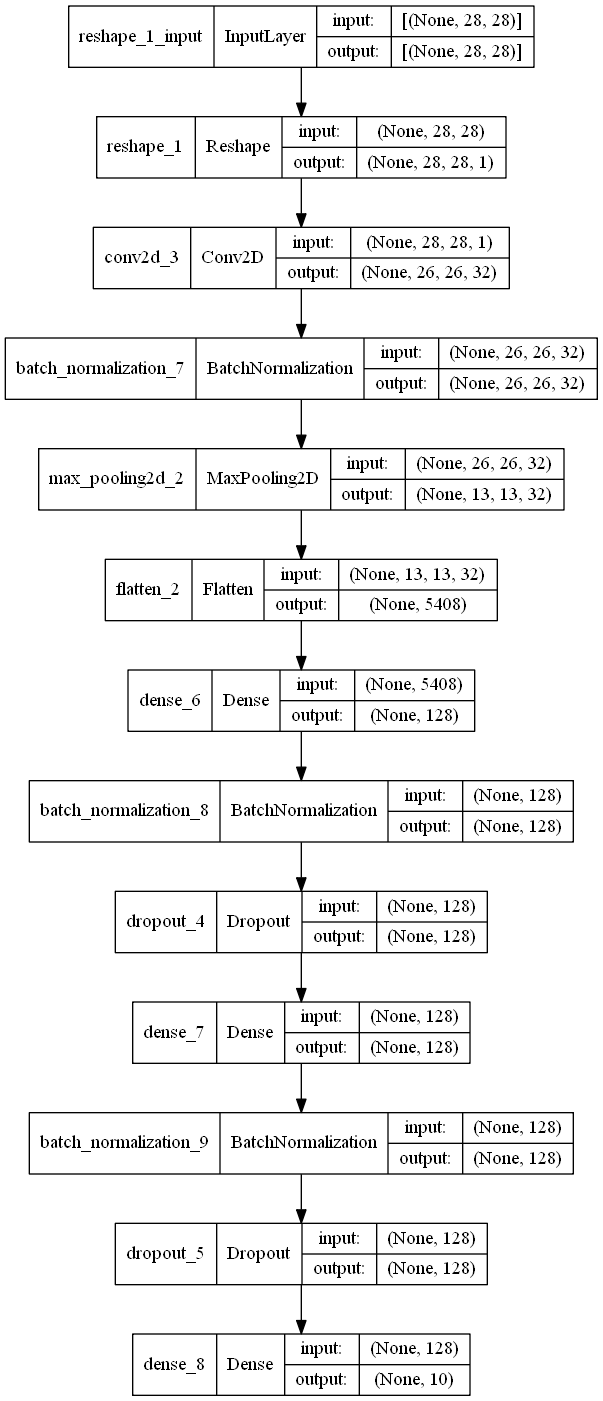

In [49]:
keras.utils.plot_model(cnn, show_shapes=True)

## Treinando a CNN

In [50]:
print('Formato dos labels:', np.unique(y_test))

# Portanto, utilizamos a função de custo 'sparse_categorical_crossentropy'

Formato dos labels: [0 1 2 3 4 5 6 7 8 9]


In [51]:
cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
cnn.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_valid, y_valid), 
        callbacks=[keras.callbacks.EarlyStopping(patience=5), 
                   keras.callbacks.ModelCheckpoint('checkpoint_cnn_mnist.h5', save_best_only=True)])

Epoch 1/10
430/430 [==============================] - 36s 81ms/step - loss: 0.1895 - accuracy: 0.9438 - val_loss: 0.1259 - val_accuracy: 0.9660
Epoch 2/10
430/430 [==============================] - 35s 81ms/step - loss: 0.0706 - accuracy: 0.9788 - val_loss: 0.0525 - val_accuracy: 0.9844
Epoch 3/10
430/430 [==============================] - 35s 82ms/step - loss: 0.0469 - accuracy: 0.9857 - val_loss: 0.0533 - val_accuracy: 0.9852
Epoch 4/10
430/430 [==============================] - 44s 102ms/step - loss: 0.0357 - accuracy: 0.9881 - val_loss: 0.0553 - val_accuracy: 0.9838
Epoch 5/10
430/430 [==============================] - 45s 105ms/step - loss: 0.0312 - accuracy: 0.9895 - val_loss: 0.0487 - val_accuracy: 0.9862
Epoch 6/10
430/430 [==============================] - 44s 102ms/step - loss: 0.0228 - accuracy: 0.9930 - val_loss: 0.0515 - val_accuracy: 0.9854
Epoch 7/10
430/430 [==============================] - 34s 78ms/step - loss: 0.0186 - accuracy: 0.9937 - val_loss: 0.0439 - val_accura

## Avaliando o Modelo

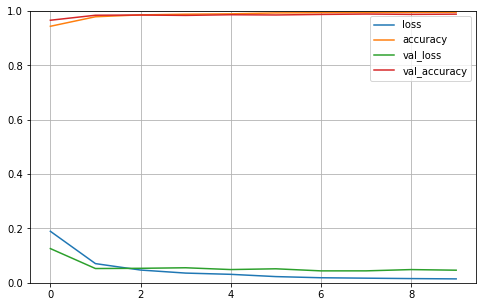

In [53]:
pd.DataFrame(cnn.history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [54]:
cnn.evaluate(X_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.0494 - accuracy: 0.9860


[0.04936471953988075, 0.9860000014305115]

In [62]:
# Prevendo uma instância. Resultado do SoftMax é no formato one-hot: 7
cnn.predict(X_test[[0]]).round(2)

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [64]:
# Ground Truth da instância prevista (corretamente):
y_test[0]

7